/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training accuracy: 0.8926
Validation/Test accuracy: 0.8938

Classification report (test):
              precision    recall  f1-score   support

           0     0.9914    0.8916    0.9389     18300
           1     0.4400    0.9171    0.5947      1700

    accuracy                         0.8938     20000
   macro avg     0.7157    0.9043    0.7668     20000
weighted avg     0.9446    0.8938    0.9096     20000

ROC AUC (test): 0.9685219704275153


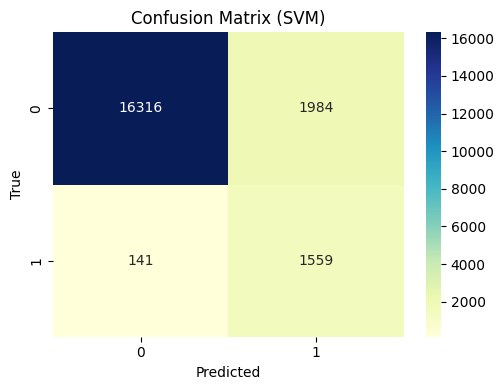

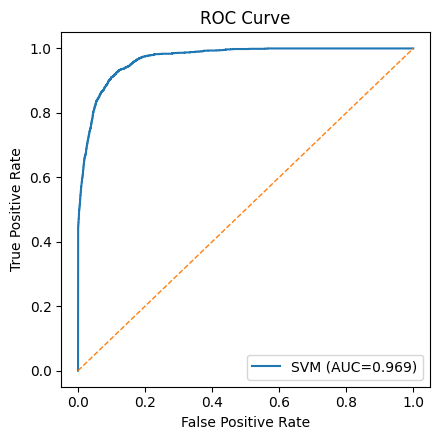

In [ ]:
# ================================
# 0) IMPORT THƯ VIỆN  (theo 2.2.2 Bài làm mẫu)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc)

RANDOM_STATE = 101

# ================================
# 1) NẠP DỮ LIỆU & TÁCH TẬP  (bám 2.2.2: bước 1)
# ================================
CSV_PATH = "/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv"  # <-- đổi nếu cần
df = pd.read_csv(CSV_PATH)

# Cột mục tiêu & đặc trưng
target_col = "diabetes"
feature_cols = [
    "gender", "age", "hypertension", "heart_disease",
    "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"
]

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

# train/test split 80:20 (giống tài liệu), dùng stratify để giữ tỷ lệ lớp
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ================================
# 2) TIỀN XỬ LÝ (impute + OHE + SCALING)  (đáp ứng mục “Hàm nào để chuẩn hóa?”)
#    - SVM rất nhạy với scale → StandardScaler cho cột số
#    - OHE cho phân loại: gender, smoking_history
# ================================
num_cols = ["age","bmi","HbA1c_level","blood_glucose_level","hypertension","heart_disease"]
cat_cols = ["gender","smoking_history"]

# OHE dense để dễ làm việc
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <1.2

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

# ================================
# 3) HUẤN LUYỆN SVM CƠ BẢN (giống mẫu: svm.SVC(), .fit, .score)
#    - Bổ sung class_weight='balanced' nếu dữ liệu lệch lớp
# ================================
base_svc = svm.SVC(kernel="rbf", C=1.0, gamma="scale",
                   probability=True, class_weight="balanced",
                   random_state=RANDOM_STATE)

svc_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("svc", base_svc)
])

svc_pipe.fit(X_train, y_train)

# Đánh giá như tài liệu (accuracy) + thêm báo cáo & ROC AUC
train_acc = svc_pipe.score(X_train, y_train)
test_acc  = svc_pipe.score(X_test,  y_test)
print(f"Training accuracy: {train_acc:.4f}")
print(f"Validation/Test accuracy: {test_acc:.4f}")

y_pred = svc_pipe.predict(X_test)
y_proba = svc_pipe.predict_proba(X_test)[:,1]
print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC (test):", roc_auc_score(y_test, y_proba))

# Confusion matrix (giống “Hình 2.5/2.6” phần digits nhưng cho bài này)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5.2,4))
sns.heatmap(pd.DataFrame(cm),
            annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# ROC curve nhanh
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(4.5,4.5))
plt.plot(fpr, tpr, label=f"SVM (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],"--",lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout(); plt.show()

# ================================
# 4) THỬ NHIỀU KERNEL (bám sát vòng lặp trong tài liệu: linear/poly/rbf/sigmoid)
# ================================
kernels = ["linear","poly","rbf","sigmoid"]
best_svm = None
best_val_acc = -1.0
best_kernel = None

results = []
for k in kernels:
    clf = Pipeline(steps=[
        ("prep", preprocess),
        ("svc", svm.SVC(kernel=k, probability=True,
                        class_weight="balanced", random_state=RANDOM_STATE))
    ])
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    results.append((k, acc))
    if acc > best_val_acc:
        best_val_acc = acc
        best_svm = clf
        best_kernel = k

print("\nKernel comparison (accuracy on test):")
for k, acc in results:
    print(f"- {k:7s}: {acc:.4f}")

print(f"\nBest validation accuracy : {best_val_acc:.4f} with kernel: {best_kernel}")

# ================================
# 5) (TUỲ CHỌN) GRIDSEARCHCV TỐI ƯU SIÊU THAM SỐ (đáp ứng câu hỏi GridSearch)
#    - Ví dụ tìm C & gamma cho RBF, và C cho linear
# ================================
param_grid = [
    {"svc__kernel":["linear"], "svc__C":[0.1, 1, 3, 10]},
    {"svc__kernel":["rbf"],    "svc__C":[0.5, 1, 3, 10], "svc__gamma":["scale", 0.1, 0.01]},
    {"svc__kernel":["poly"],   "svc__C":[0.5, 1, 3],     "svc__degree":[2,3], "svc__gamma":["scale"]},
]

grid = GridSearchCV(
    estimator=Pipeline(steps=[("prep", preprocess),
                              ("svc", svm.SVC(probability=True,
                                              class_weight="balanced",
                                              random_state=RANDOM_STATE))]),
    param_grid=param_grid,
    scoring="roc_auc",   # với bài y sinh học, ROC AUC thường hữu ích hơn
    cv=4, refit=True, n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("\nBest params (GridSearchCV):", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

# Đánh giá mô hình tối ưu trên test
y_pred_gs  = grid.predict(X_test)
y_proba_gs = grid.predict_proba(X_test)[:,1]
print("\n[GridSearch] Test accuracy:", accuracy_score(y_test, y_pred_gs))
print("[GridSearch] Test ROC AUC:", roc_auc_score(y_test, y_proba_gs))
print("\n[GridSearch] Classification report:")
print(classification_report(y_test, y_pred_gs, digits=4))

cm_gs = confusion_matrix(y_test, y_pred_gs)
plt.figure(figsize=(5.2,4))
sns.heatmap(pd.DataFrame(cm_gs), annot=True, fmt="d", cmap="YlOrBr")
plt.title("Confusion Matrix (SVM - GridSearch best)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()
